# Tratamiento de imágenes - 2023 - Entregable 3

# Fecha de entrega: 04/6/2023

In [227]:
import os
import numpy as np
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
pi = np.pi

%matplotlib notebook

def read_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            image = cv.imread(image_path)
            if image is not None:
                if image.ndim>2: 
                    image = image[:,:,0]
                images.append(image)
    return images


def Fths(img, val):
    ret_img = np.ones(img.shape)
    m,n = img.shape
    for k in range(m):
        for l in range(n):
            if img[k,l]>val:
                ret_img[k,l]=255
            else:
                ret_img[k,l]=0
    return ret_img

df = pd.read_csv('C:/Users/tomas/TIMAG/Proyecto/DataBase/timag_2023_glint_dataset_gt.csv')

Funciones auxiliares para graficar

In [229]:
def C_center(contour):
    '''
    Calcula los centros de los contornos contour.
    Devuelve los centros de estos
    
    Parameters
    ----------
    contour : OutputArrayOfArrays
        Contornos formado por con los pixeles que lo conforman.

    Returns
    -------
    center : list Nx2
        Lista con los centros de los contornos.
    '''
    center = [0,0]
    # calculate countour center and draw a dot there
    m = cv.moments(contour)
    if m['m00'] != 0:
        center = (int(m['m10'] / m['m00']), int(m['m01'] / m['m00']))
        
    #in some cases we dont have enough points and the M00 is 0, we aprox the center with the first value of the list
    #(couse there are few values, is a relative safe aprox.)
    else:
        aprox_center = contour[0]
        center = (aprox_center[0,0],aprox_center[0,1])
    return center

### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### ####

def C_plot(img, contours, ellipse, title='Drawing'):
    '''
    Grafica los contornos y sus respecivos centros. En cada de tener elpsie, lo grafica en vez del centro del contorno

    Parameters
    ----------
    img : Imagen de 256 niveles de gris (uint8)  
    contour : OutputArrayOfArrays
        Contornos formado por con los pixeles que lo conforman.
    ellipse : OutputArrayOfArrays
        Elpise formado por con los pixeles que lo conforman.
    title : string
        Titulo de la gráfica.
    '''
    drawing = np.copy(img)
    cv.drawContours(drawing, contours, -1, (255, 0, 0), 1)
    
    #if is not empty we plot ellipse
    if ellipse!=0 and ellipse!=999:
        cv.ellipse(drawing, box=ellipse, color=(0, 0, 0))
    
    center = [0,0]
    for contour in contours:
        m = cv.moments(contour)
        if m['m00'] != 0:
            center = (int(m['m10'] / m['m00']), int(m['m01'] / m['m00']))            
        else:
            if ellipse==0: #dont use it with pupils
                aprox_center = contour[0]
                center = (aprox_center[0,0],aprox_center[0,1])
        cv.circle(drawing, center, 3, (0, 255, 0), -1)           
    cv.namedWindow(title, cv.WINDOW_NORMAL)
    cv.resizeWindow(title, 700, 700)
    cv.imshow(title, drawing)
    
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    return 0

### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### ####

def error_dist_plt(pixel_error,label,color,symb,title=False,fig_n=0,xlabel='Detection error (px)',ylabel='Percentage of frames',max_pixel_error=140,slices=8,xy_lim_offset = 5):
    '''
    Graficas de error para glints y pupil.

    Parameters
    ----------
    pixel_error : array 
        Distancia en pixeles del error de la estimación de glints/pupil.
    label : string
        Texto con la versión del detector.
    color : string
        Color de la gráfica.
    symb : string
        Symbolos con que se grafica. 
    title : string
        Titulo de la gráfica.
    fig_n : int
        Número de id de la figura.
    xlabel : string
        Titulo del eje Ox.
    ylabel : string
        TTitulo del eje Oy.
    max_pixel_error : int
        Numero máximo de pixeles que se grafica.
    slices : int
        Número de separaciones entre 0 y max_pixel_error.
    xy_lim_offset : int
        Offset de los extremos de la gráfica.
    '''
    
    
    if fig_n!=0: plt.figure(fig_n)
    else: plt.figure()
       
    Ox = np.linspace(0,max_pixel_error,slices)
     

    #pupil case
    if len(pixel_error)==1:
        pupil_error = np.array(pixel_error[0])
        counter_of_img = np.zeros([len(Ox)], dtype='int')
        
        for idx, val in enumerate(Ox): counter_of_img[idx] = len(np.where(pupil_error<=val)[0])
        N_images = len(pupil_error)    
        percentage = (counter_of_img/N_images)*100    
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)

        plt.plot(Ox,percentage,symb,color=color,label='Pupil detector')
        plt.legend(loc=2)
        plt.xlim(-xy_lim_offset,max_pixel_error+xy_lim_offset)
        plt.ylim(-xy_lim_offset,100+xy_lim_offset)
        
        if title!=False:
            plt.title(title)
            
    #glint case  
    else:
        L_glint_error = np.array(pixel_error[0])
        R_glint_error = np.array(pixel_error[1])
        
        counter_of_img_L = np.zeros([len(Ox)], dtype='int')
        counter_of_img_R = np.zeros([len(Ox)], dtype='int')
        for idx, val in enumerate(Ox):
            counter_of_img_L[idx] = len(np.where(L_glint_error<=val)[0])
            counter_of_img_R[idx] = len(np.where(R_glint_error<=val)[0])
 
        N_images = len(L_glint_error)
        percentageL = (counter_of_img_L/N_images)*100
        percentageR = (counter_of_img_R/N_images)*100
     
        plt.subplot(2,1,1)
        plt.grid(True)
        plt.plot(Ox,percentageL,symb,color=color,label=label)
        plt.legend(loc=2)
        plt.xlim(-xy_lim_offset,max_pixel_error+xy_lim_offset)
        plt.ylim(-xy_lim_offset,100+xy_lim_offset)
        plt.ylabel(ylabel)
        plt.title('Detection error of left/right glint')
        
        plt.subplot(2,1,2)
        plt.grid(True)
        plt.plot(Ox,percentageR,symb,color=color,label=label)
        plt.legend(loc=2)
        plt.xlim(-xy_lim_offset,max_pixel_error+xy_lim_offset)
        plt.ylim(-xy_lim_offset,100+xy_lim_offset)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        #both glints error
        glint_error = L_glint_error+R_glint_error
        
        counter_of_img = np.zeros([len(Ox)], dtype='int')
        for idx, val in enumerate(Ox):
            counter_of_img[idx] = len(np.where(glint_error<=val)[0])
        percentage = (counter_of_img/N_images)*100
        if fig_n!=0: plt.figure(fig_n+1)
        else: plt.figure()
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.xlim(-xy_lim_offset,max_pixel_error+xy_lim_offset)
        plt.ylim(-xy_lim_offset,100+xy_lim_offset)

        plt.plot(Ox,percentage,symb,color=color,label=label)
        plt.legend(loc=2)
        if title!=False:
            plt.title(title)
    
    return 0

Funcion auxiliar del detector de glints.

In [230]:
def idx_selector(glint_center, glint_idx,RANGE=5,optimal_dist=6): 
    '''
    Selector de índices de contornos según la distancia relativa entre los centros de los mismos.

    Parameters
    ----------
    glint_center : array
        Lista con los centros de los contornos.
    glint_idx : array
        Indices globales de los contornos.
    RANGE : int
        Rango vertical para agrupar los puntos.
    optimal_dist : int
        Distancia horizontal que se considera óptima entre los puntos

    Returns
    -------
    min_idX : array 
        Indices de los contornos más probables de ser glints.
    '''
    
    glint_idx = np.array( glint_idx)
    min_idX = np.ones(2, dtype=int)*-1
    
    visited = []   
    min_dist = 1e10
    
    #we form grups based on verical proximity and later we take into consideration horizontal distance
    for Oy_idx, Oy in enumerate(glint_center[:,1]):
        if not (Oy in visited):
            #find points in the same horizontal value
            
            #there are the relative indexes and the real indexes(the ones that we use as the return)
            relative_idx = np.where(np.abs(glint_center[:,1]-Oy)<RANGE)[0]                       
            
            for val in glint_center[:,1][relative_idx]: visited.append(val)
                       
            #dont continue if we fond a group with only one member (isolated point)
            if relative_idx.shape[0]<=1: continue 

            #for each group we find the vertical distance
            for Ox_idx,Ox in enumerate(glint_center[:,0][relative_idx]):
                dist = np.abs(Ox-glint_center[:,0][relative_idx])-optimal_dist 
                
                #the points against himself
                idx = np.where(dist==-optimal_dist)
                dist[idx] = 1e6
                dist = np.abs(dist)
                aux_min_dist = np.min(dist)

                if (aux_min_dist<min_dist): 

                    min_dist = aux_min_dist

                    loop_idx = np.where(dist==min_dist)[0]
                    if len(loop_idx)>1: loop_idx=loop_idx[0]
                    
                    min_idX[0] = glint_idx[relative_idx][Ox_idx]
                    min_idX[1] = glint_idx[relative_idx][loop_idx]
    return min_idX

Detector de pupilas

In [231]:
def P_detector(img):
    '''
    Detector de pupilas

    Parameters
    ----------
    img : Imagen de 256 niveles de gris (uint8)

    Returns
    -------
    contours[idx] : OutputArrayOfArrays
        Contorno de la posible pupila.
    ret_ellipse : OutputArrayOfArrays
        Elipse que mejor se adapta al contorno de la pupila.
     error : int
        Número que sirve para identificar erroes.
    '''
    idx=-1
    error = 1
    ret_ellipse = 0
    
    retval, thresholded = cv.threshold(img, 50, 255, 0)
    closed = cv.erode(cv.dilate(thresholded, kernel, iterations=1), kernel, iterations=1)

    #the last contour is of the image borders, by extend i dont consider it    
    contours, hierarchy = cv.findContours(closed, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

    for contour_idx, contour in enumerate(contours):

                 ###########################
                ###REJECTION OF CONTOURS###
               ###########################

        #verify a minimum area 
        area = cv.contourArea(contour)
        if area < 100:
            continue

        # reject the contours with big extend over the box
        bounding_box = cv.boundingRect(contour) #x,y,w,h of the box  
        extend = area / (bounding_box[2] * bounding_box[3])
        if extend > 0.8:
            continue

        # fit an ellipse around the contour and draw it into the image     
        try:
            ellipse = cv.fitEllipse(contour)
            cv.ellipse(drawing, box=ellipse, color=(0, 0, 0))

            relWH = np.abs(ellipse[1][0]/ellipse[1][1])
            rel_min = 0.25
            rel_max = 1.75

            if (relWH<rel_min) or (relWH>rel_max):
                continue
        except:
            pass
        
        #return only one contourn (the first one)
        if idx == -1:
            idx = contour_idx 
            ret_ellipse = ellipse
            error = 0
            
    if error == 1:
        #by default return first contour
        idx = 0    

    return contours[idx], ret_ellipse, error

Detector de glints

In [232]:
def G_detector(img,L_threshold, ver=0):  
    '''
    Detector de pupilas

    Parameters
    ----------
    img : Imagen de 256 niveles de gris (uint8)
    L_threshold : int
        Umbral inferior.
    ver : int
        Versión a usar del detector.
    Returns
    -------
    [contours[idxL],contours[idxR]] : OutputArrayOfArrays
        Contornos de los posibles glints.
    L_threshold : int
        Umbral inferior.
     error_code : int
        Número que sirve para identificar erroes.
    '''
    #by default return first contour
    idxL=1 
    idxR=0
    error_code = 0

    retval, thresholded = cv.threshold(img, L_threshold, 255, 0)
    closed = cv.erode(cv.dilate(thresholded, kernel, iterations=1), kernel, iterations=1)

    #the last contour is of the image borders, by extend i dont consider it    
    contours, hierarchy = cv.findContours(closed, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

    #case where we didnt find enough contours
    if len(contours)<=2: return [0,0], L_threshold, 1

    glint_idx, glint_center = np.ones([len(contours)],dtype=int)*(-1), np.ones([len(contours),2],dtype=int)*(-1)
    for contour_idx, contour in enumerate(contours):

        area = cv.contourArea(contour)
        if area > 20:
            continue

        #x,y,w,h of the box
        bounding_box = cv.boundingRect(contour) 

        extend = area / (bounding_box[2] * bounding_box[3])

        # reject the contours with big extend over the box
        if extend > 0.8:
            continue


        glint_center[contour_idx,:] = C_center(contour)
        glint_idx[contour_idx] = contour_idx
    
    #get rid off the centers of discard contours (ver 2get rid of (0,0 too))    
    del0, del1 = np.where(glint_center==0)[0][1::2], np.where(glint_center==-1)[0][1::2]
    del_row = np.append(del0, del1, 0)
    glint_center = np.delete(glint_center, del_row, 0)  
    glint_idx = np.delete(glint_idx, del_row, 0)  
    
    #in ver 1 we take into consideration the horizontal position 
    if ver==1:       
               
        #return the idxs of the best mached contours
        #in case that the number of contours doesnt reach the minimum number to compare
        if len(glint_center)==2:
            idxL, idxR = glint_idx[1], glint_idx[0]
        elif len(glint_center)==1:
            idxL,idxR = glint_idx[0], 0
        elif len(glint_center)==0:
            idxL,idxR = 1, 0
        else:
            idx_return = idx_selector(glint_center, glint_idx)
            
            #in case we dont find indexes with the fun
            if (idx_return[0]==-1 or idx_return[1]==-1):
                idxL,idxR = 1, 0
            else:
                idxL,idxR = idx_return[1], idx_return[0]    
                
### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### ####
                
    # Dinamic thresholds
    if ver==2:
        offset = 9 #9
        hist = cv.calcHist([img],[0],None,[256],[0,256])

        hist_mean = np.mean(hist)
        hist_max = np.max(hist)
        L_threshold = np.where(hist == hist_max)[0][0] + offset
  
        #recursive use of the funtion
        ret = G_detector(img, L_threshold, ver=1)
        return ret
    
### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### #### ### #### ####
    
    #+pupil info and change in dynamic th offset
    #with the pupil info i can not erode and the noise (isolated points) doesnt seem to bother me
    if ver==3:
    
        #### Dynamic th ####
        offset = 0 #9
        hist = cv.calcHist([img],[0],None,[256],[0,256])


        hist_mean = np.mean(hist)
        hist_max = np.max(hist)
        L_threshold = np.where(hist == hist_max)[0][0] + offset
        #### Dynamic th ####
        
        #### default run ####
        idxL=1 #by default return first contour
        idxR=0
        error_code = 0

        retval, thresholded = cv.threshold(img, L_threshold, 255, 0)
        closed = thresholded

        #the last contour is of the image borders, by extend i dont consider it    
        contours, hierarchy = cv.findContours(closed, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

        #case where we didnt find enough contours
        if len(contours)<=2: return [0,0], L_threshold, 1

        glint_idx, glint_center = np.ones([len(contours)],dtype=int)*(-1), np.ones([len(contours),2],dtype=int)*(-1)
        for contour_idx, contour in enumerate(contours):

            area = cv.contourArea(contour)
            if area > 20: #20
                continue

            #x,y,w,h of the box
            bounding_box = cv.boundingRect(contour) 

            extend = area / (bounding_box[2] * bounding_box[3])

            # reject the contours with big extend over the box
            if extend > 0.8:
                continue


            glint_center[contour_idx,:] = C_center(contour)
            glint_idx[contour_idx] = contour_idx

        #get rid off the centers of discard contours (ver 2get rid of (0,0 too))    
        del0, del1 = np.where(glint_center==0)[0][1::2], np.where(glint_center==-1)[0][1::2]
        del_row = np.append(del0, del1, 0)
        glint_center = np.delete(glint_center, del_row, 0)  
        glint_idx = np.delete(glint_idx, del_row, 0)  
        ### default run ####
        
        ### ver3 ####   
        #use an array of dist in case we dont find 
        max_dist_arr = np.array([15,20,25,30,40,50])
        
        Pcontour,_,_ = P_detector(img)
        Pcenter = C_center(Pcontour) 
        
        for max_dist in max_dist_arr:
            delFLAG = 0
            del_out = []
            for idx, val in enumerate(glint_center): 
                distX = np.abs(val[0]-(Pcenter[0]))
                distY = np.abs(val[1]-(Pcenter[1]))
                if (distX>max_dist) or (distY>max_dist): delFLAG=1 
                if delFLAG: del_out.append(idx)
                delFLAG = 0
            
            glint_center_del = np.delete(glint_center, del_out, 0) 
            glint_idx_del = np.delete(glint_idx, del_out, 0) 
            
            if len(glint_center_del)>=2: 
                glint_center = glint_center_del
                glint_idx = glint_idx_del
                break
        ### ver3
               
        ### ver1
        if len(glint_center)==2:
            idxL, idxR = glint_idx[1], glint_idx[0]
        elif len(glint_center)==1:
            idxL,idxR = glint_idx[0], 0
        elif len(glint_center)==0:
            idxL,idxR = 1, 0
        else:
            idx_return = idx_selector(glint_center, glint_idx)
            
            #in case we dont find indexes with the fun
            if (idx_return[0]==-1 or idx_return[1]==-1):
                idxL,idxR = 1, 0
            else:
                idxL,idxR = idx_return[1], idx_return[0]
        ### ver1
        
    return [contours[idxL],contours[idxR]], L_threshold, error_code

MAIN

<IPython.core.display.Javascript object>


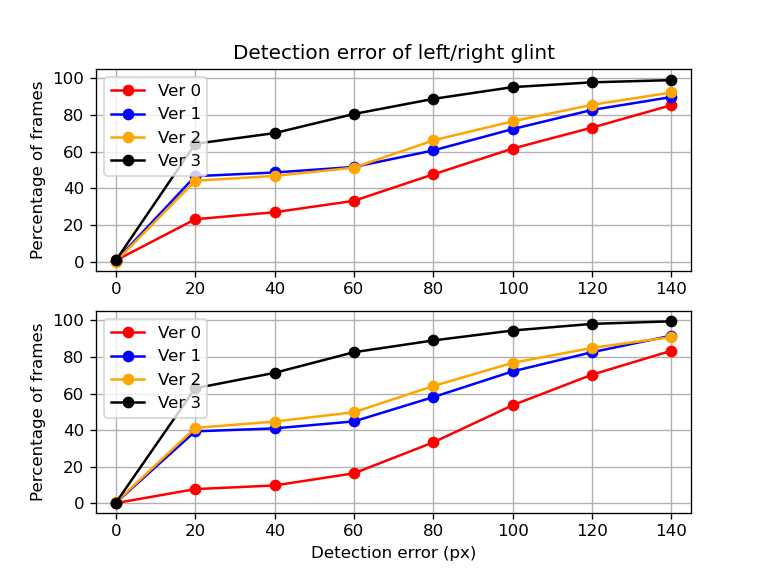

<IPython.core.display.Javascript object>


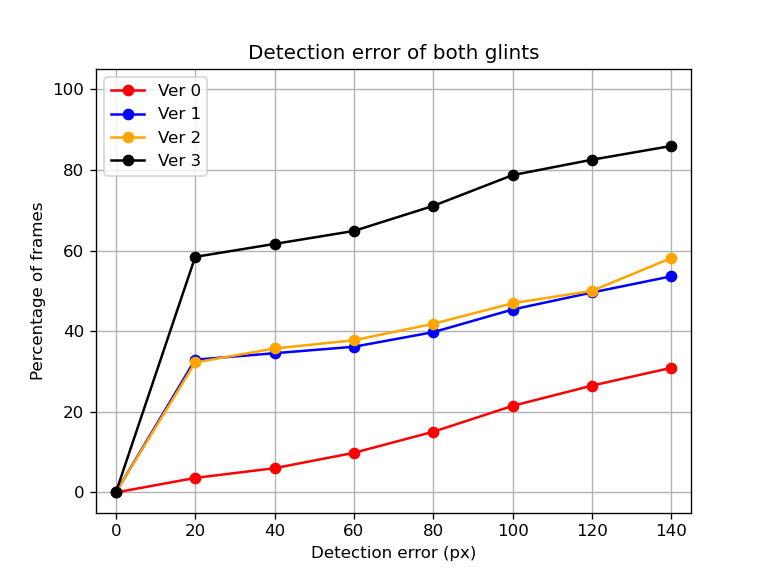

<IPython.core.display.Javascript object>


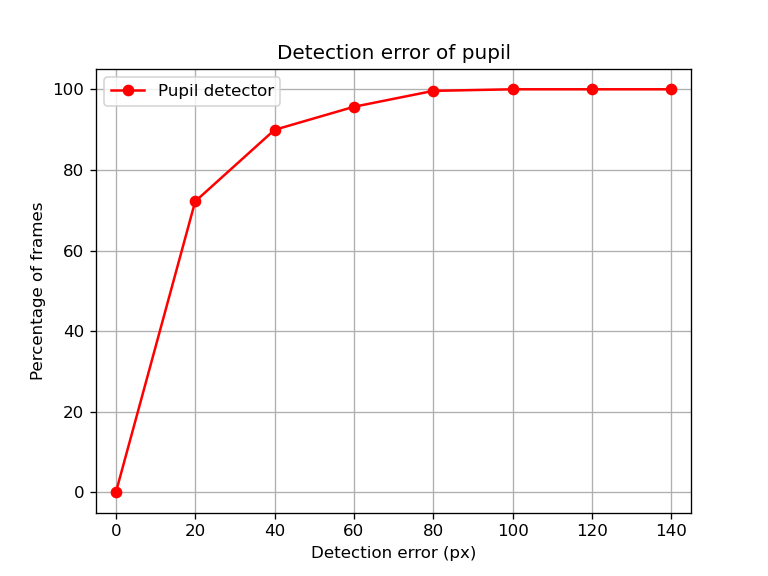

0

In [233]:
folder_path = 'C:/Users/tomas/TIMAG/Proyecto/DataBase/'
images = read_images_from_folder(folder_path)


kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))

#right glint
XR, YR = df['glint1_X'], df['glint1_Y']
#left glint
XL, YL = df['glint2_X'], df['glint2_Y']
#pupil
X, Y, mask = df['pupil_X'], df['pupil_Y'], df['mask']


dif_ver = 4

symb = '-o'
palete = ['red','blue','orange','k']  

for ver in range(dif_ver):
    
    #int the case of the glint we have two points to mesure the error
    C_pixel_error, C_pixel_error_accumulator = [[],[]], [[0],[0]]
    P_pixel_error, P_pixel_error_accumulator = [], [0]
        
    for img_idx, img in enumerate(images):
        mask_val = mask[img_idx]
        if mask_val:

            #PUPILS  
            Pcontour, ellipse, error = P_detector(img)
            Pcenter = C_center(Pcontour)
            
            #if cant fit an ellipse            
            if ellipse==0: ellipse=999

#             C_plot(img,Pcontour,ellipse,'Detected pupils in img '+str(img_idx)) 

            #verify with df
            Pdif = np.abs(X[img_idx]-Pcenter[0])+np.abs(Y[img_idx]-Pcenter[1])
            P_pixel_error.append(Pdif)
            
            #GLINTS DETECTION
            Gcontours, th_used, error_code = G_detector(img, 85, ver)
            
#             C_plot(img,Gcontours,0,'Detected pupils in img '+str(img_idx)+' ver '+str(ver)) 

            #loop over the two contours, the first one is left (LR=0)
            if error_code!=0: continue
            for LR, Gcontour in enumerate(Gcontours): 
                Gcenter = C_center(Gcontour)

                XC = XL[img_idx]
                YC = YL[img_idx]
                #is true in the right glint
                if LR: 
                    XC = XR[img_idx]
                    YC = YR[img_idx]

                ###verify with df
                Cdif = np.abs(XC-Gcenter[0]) + np.abs(YC-Gcenter[1])
                C_pixel_error[LR].append(Cdif) 


    
    error_dist_plt(C_pixel_error,'Ver '+str(ver), palete[ver],symb,'Detection error of both glints',2)
error_dist_plt([P_pixel_error],'Ver '+str(ver), palete[0],symb,'Detection error of pupil',1)